In [1]:
#!/usr/bin/env python

# Import Required Packages
# ========================
import os, sys
import math
import pickle

import casadi
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy as sp

sys.path.append(os.path.abspath("mcmc"))
from mcmc_sampling import create_hmc_sampler

# Local Debugging flag; remove when all tested
_DEBUG = False 

In [2]:
def multivariate_normal_log_probability(z, mean, cov):
    """
    Evaluate and return the log-probability of a (unnormalized) multivariate normal distribution.

    :param z: value of the multivariate normal random variable
    :param mean: (1d array/list); mean of the normal distribution
    :param cov: (2D array) covariance matrix

    :returns: log-probability of a (unnormalized) multivariate normal distribution
    """
    z    = np.asarray(z, dtype=float).flatten()
    mean = np.asarray(z, dtype=float).flatten()
    cov = np.asarray(cov, dtype=float).squeeze()

    # Assert/Check input types/shapes
    assert mean.size == z.size, "mismatch between variable and mean sizes/shapes"
    if mean.size > 1:
        assert cov.shape == (z.size,z.size), "mismatch between variable and covariances `cov` shape"

    elif mean.size == 1:
        assert cov.size == 1, "mismatch between variable and covariances `cov` shape"
        cov = np.reshape(cov, (1, 1))

    else:
        print("Invalid covariance matrix shape!")
        raise AssertionError

    # Evaluate the log-probability
    dev      = z - mean
    scld_dev = np.linalg.inv(cov).dot(dev)
    log_prob = - 0.5 * np.dot(dev, scld_dev)

    return log_prob

In [3]:
def load_site_data(file="data/calibration_10SitesModel.csv", 
                   norm_fac=1.0,
                  ):
    """
    Load site data

    :returns:
        -
    """
    # Read data file
    df = pd.read_csv(file)

    # Extract information
    z_2017_10Sites             = df['z_2017_10Sites'].to_numpy()
    zbar_2017_10Sites          = df['zbar_2017_10Sites'].to_numpy()
    gamma_10Sites              = df['gamma_10Sites'].to_numpy()
    gammaSD_10Sites            = df['gammaSD_10Sites'].to_numpy()
    forestArea_2017_ha_10Sites = df['forestArea_2017_ha_10Sites'].to_numpy()
    theta_10Sites              = df['theta_10Sites'].to_numpy()

    # Normalize Z data
    zbar_2017_10Sites /= norm_fac
    z_2017_10Sites    /= norm_fac
    
    return (zbar_2017_10Sites,
            gamma_10Sites,
            gammaSD_10Sites,
            z_2017_10Sites,
            forestArea_2017_ha_10Sites,
            theta_10Sites
            )

In [4]:
# Verbose Data check (eyeball check!)
zbar_2017_10Sites, gamma_10Sites, gammaSD_10Sites, \
            z_2017_10Sites, forestArea_2017_ha_10Sites, theta_10Sites = load_site_data(norm_fac=1e+9)
print("gamma_10Sites", gamma_10Sites)
print("gammaSD_10Sites", gammaSD_10Sites)
print("z_2017_10Sites", z_2017_10Sites)
print("gamma_10Sites - gammaSD_10Sites", gamma_10Sites - gammaSD_10Sites)
print("zbar_2017_10Sites", zbar_2017_10Sites)

gamma_10Sites [528.37325404 775.47438931 395.26648222 374.48793533 264.38850068
 629.55636429 525.40049002 647.83704716 655.24936145 515.34274728]
gammaSD_10Sites [238.11314476 326.38539421 186.89564803 181.8379563  134.00071021
 271.3797981  249.13116229 258.88173247 291.55140499 205.48669328]
z_2017_10Sites [6.39629863e-03 6.67577070e-04 1.60344839e-02 9.49710184e-03
 6.04574833e-03 2.70778687e-03 7.79948366e-03 5.73571943e-05
 6.77236678e-03 1.30112628e-03]
gamma_10Sites - gammaSD_10Sites [290.26010928 449.0889951  208.37083419 192.64997903 130.38779047
 358.17656618 276.26932772 388.95531469 363.69795645 309.856054  ]
zbar_2017_10Sites [0.04586502 0.03280152 0.03713347 0.02052573 0.01063091 0.07698995
 0.02063136 0.03375215 0.05417736 0.06184899]


In [5]:
def log_density_function(gamma_val,
                         gamma_vals_mean,
                         theta_vals,
                         site_precisions,
                         alpha,
                         sol,
                         X,
                         Ua,
                         Up,
                         zbar_2017_10Sites,
                         forestArea_2017_ha_10Sites,
                         norm_fac,
                         alpha_p_Adym,
                         Bdym,
                         leng,
                         T,
                         ds_vect,
                         zeta,
                         xi,
                         kappa,
                         pa,
                         pf,
                         ):
    """
    Define a function to evaluate log-density of the objective/posterior distribution
    Some of the input parameters are updated at each cycle of the outer loop (optimization loop),
    and it becomes then easier/cheaper to udpate the function stamp and keep it separate here
    """
    N          = X.shape[1] - 1
    
    gamma_val  = np.asarray(gamma_val).flatten()
    gamma_size = gamma_val.size
    x0_vals    = gamma_val.T.dot(forestArea_2017_ha_10Sites) / norm_fac
    X_zero     = np.sum(x0_vals) * np.ones(leng)
    
    
    # shifted_X = zbar_2017_10Sites - sol.value(X)[0:gamma_size, :-1]
    shifted_X  = sol.value(X)[0: gamma_size, :-1].copy()
    for j in range(N): 
        shifted_X[:, j]  = zbar_2017_10Sites - shifted_X[:, j]
    omega      = np.dot(gamma_val, alpha * shifted_X - sol.value(Up))
    
    X_dym      = np.zeros(T+1)
    X_dym[0]   = np.sum(x0_vals)
    X_dym[1: ] = alpha_p_Adym * X_zero  + np.dot(Bdym, omega.T)

    z_shifted_X = sol.value(X)[0: gamma_size, :].copy()
    scl = pa * theta_vals - pf * kappa
    for j in range(N+1): z_shifted_X [:, j] *= scl
    
    term_1 = - casadi.sum2(np.reshape(ds_vect[0: T], (1, T)) * sol.value(Ua) * zeta / 2 )
    term_2 = casadi.sum2(np.reshape(ds_vect[0: T], (1, T)) * pf * (X_dym[1: ] - X_dym[0: -1]))
    term_3 = casadi.sum2(np.reshape(ds_vect, (1, N+1)) * casadi.sum1(z_shifted_X))
    
    obj_val = term_1 + term_2 + term_3
    
    gamma_val_dev   = gamma_val - gamma_vals_mean
    norm_log_prob   =   - 0.5 * np.dot(gamma_val_dev,
                                       site_precisions.dot(gamma_val_dev)
                                       )
    log_density_val = -1.0  / xi * obj_val + norm_log_prob

    if _DEBUG:
        print("Term 1: ", term_1)
        print("Term 2: ", term_2)
        print("Term 3: ", term_3)
        print("obj_val: ", obj_val)
        print("norm_log_prob", norm_log_prob)
        print("log_density_val", log_density_val)

    return log_density_val

In [6]:
def main(
    # Configurations/Settings
    norm_fac = 1e9,
    delta_t  = 0.02,
    alpha    = 0.045007414,
    kappa    = 2.094215255,
    pf       = 20.76,
    pa       = 44.75,
    xi       = 15,
    zeta     = 1.66e-4*1e9,  # zeta := 1.66e-4*norm_fac  #
    #
    tol      = 0.02,
    T        = 200,
    N        = 200,
    max_iter = 10,
    #
    sample_size=10000,  # simulations; use 10000 for testing, then reset to 100_000
    ):
    """
    Main function; putting things together

    :param float tol: convergence tolerance
    :param T:
    :param N:
    """
    

    # Load sites' data
    zbar_2017_10Sites, gamma_10Sites, gammaSD_10Sites, \
        z_2017_10Sites, forestArea_2017_ha_10Sites, theta_10Sites \
        = load_site_data(norm_fac=norm_fac)


    # Evaluate Gamma values ()
    gamma_1_vals  = gamma_10Sites -  gammaSD_10Sites
    gamma_2_vals  = gamma_10Sites +  gammaSD_10Sites
    gamma_size    = gamma_10Sites.size

    # Evaluate mean and covariances from site data
    site_stdev       = gammaSD_10Sites
    site_covariances = np.diag(np.power(site_stdev, 2))
    site_precisions  = np.linalg.inv(site_covariances)
    site_mean        = gamma_1_vals/2 + gamma_2_vals/2

    # Retrieve z data for selected site(s)
    site_z_vals  = z_2017_10Sites

    # Initialize Gamma Values
    gamma_vals      = gamma_10Sites.copy()
    gamma_vals_mean = gamma_10Sites.copy()
    gamma_vals_old  = gamma_10Sites.copy()

    # Theta Values
    theta_vals  = theta_10Sites

    # Householder to track sampled gamma values
    # gamma_vals_tracker       = np.empty((gamma_vals.size, sample_size+1))
    # gamma_vals_tracker[:, 0] = gamma_vals.copy()
    gamma_vals_tracker = [gamma_vals.copy()]

    # Collected Ensembles over all iterations; dictionary indexed by iteration number
    collected_ensembles = {}

    # Track error over iterations
    error_tracker = []

    # Update this parameter (leng) once figured out where it is coming from
    leng = 200
    arr  = np.cumsum(
             np.triu(
             np.ones((leng, leng))
         ),
         axis=1,
    ).T
    Bdym         = (1-alpha) ** (arr-1)
    Bdym[Bdym>1] = 0.0
    Adym         = np.arange(1, leng+1)
    alpha_p_Adym = np.power(1-alpha, Adym)

    # Initialize Blocks of the A matrix those won't change
    A  = np.zeros((gamma_size+2, gamma_size+2))
    Ax = np.zeros(gamma_size+2)

    # Construct Matrix B
    B = np.eye(N=gamma_size+2, M=gamma_size, k=0)
    B = casadi.sparsify(B)

    # Construct Matrxi D constant blocks
    D  = np.zeros((gamma_size+2, gamma_size))

    # time step!
    dt = T / N

    # Other placeholders!
    ds_vect = np.exp(- delta_t * np.arange(N+1) * dt)
    ds_vect = np.reshape(ds_vect, (ds_vect.size, 1))

    # Results dictionary
    results = dict(
        gamma_size=gamma_size,
        tol=tol,
        T=T,
        N=N,
        norm_fac=norm_fac,
        delta_t=delta_t,
        alpha=alpha,
        kappa=kappa,
        pf=pf,
        pa=pa,
        xi=xi,
        zeta=zeta,
    )

    # Initialize error & iteration counter
    error = np.infty
    cntr = 0

    # Loop until convergence
    while cntr < max_iter and error > tol:

        # Update x0
        x0_vals = gamma_vals * forestArea_2017_ha_10Sites / norm_fac

        # Construct Matrix A from new gamma_vals
        A[: -2, :]        = 0.0
        Ax[0: gamma_size] = - alpha * gamma_vals[0: gamma_size]
        Ax[-1]            = alpha * np.sum(gamma_vals * zbar_2017_10Sites)
        Ax[-2]            = - alpha
        A[-2, :]          = Ax
        A[-1, :]          = 0.0
        A = casadi.sparsify(A)

        # Construct Matrix D from new gamma_vals
        D[:, :]  = 0.0
        D[-2, :] = -gamma_vals
        D = casadi.sparsify(D)
        
        # Define the right hand side (symbolic here) as a function of gamma
        gamma = casadi.MX.sym('gamma' , gamma_size+2)
        up    = casadi.MX.sym('up', gamma_size)
        um    = casadi.MX.sym('um', gamma_size)

        rhs = (A @ gamma + B @ (up-um) + D @ up) * dt + gamma
        f = casadi.Function('f', [gamma, um, up], [rhs])
        

        ## Define an optimizer and initialize it, and set constraints
        opti = casadi.Opti()

        # Decision variables for states
        X = opti.variable(gamma_size+2, N+1)

        # Aliases for states
        Up = opti.variable(gamma_size, N)
        Um = opti.variable(gamma_size, N)
        Ua = opti.variable(1, N)

        # 1.2: Parameter for initial state
        ic = opti.parameter(gamma_size+2)

        # Gap-closing shooting constraints
        for k in range(N):
            opti.subject_to(X[:, k+1] == f(X[:, k], Um[:, k], Up[:, k]))

        # Initial and terminal constraints
        opti.subject_to(X[:, 0] == ic)
        opti.subject_to(opti.bounded(0,
                                     X[0: gamma_size, :],
                                     zbar_2017_10Sites[0: gamma_size]
                                     )
                        )

        # Objective: regularization of controls
        for k in range(gamma_size):
            opti.subject_to(opti.bounded(0, Um[k,:], casadi.inf))
            opti.subject_to(opti.bounded(0, Up[k,:], casadi.inf))

        opti.subject_to(Ua == casadi.sum1(Up+Um)**2)

        # Set teh optimization problem
        term1 = casadi.sum2(ds_vect[0: N, :].T * Ua * zeta / 2) 
        term2 = - casadi.sum2(ds_vect[0: N, :].T * (pf * (X[-2, 1: ] - X[-2, 0 :-1])))
        term3 = - casadi.sum2(ds_vect.T * casadi.sum1( (pa * theta_vals - pf * kappa ) * X[0: gamma_size, :] ))
        
        opti.minimize(term1 + term2 + term3)

        # Solve optimization problem
        options               = dict()
        options["print_time"] = False
        options["expand"]     = True
        options["ipopt"]      = {'print_level':                      0,
                                 'fast_step_computation':            'yes',
                                 'mu_allow_fast_monotone_decrease':  'yes',
                                 'warm_start_init_point':            'yes',
                                 }
        opti.solver('ipopt', options)
        opti.set_value(ic,
                       casadi.vertcat(site_z_vals,
                                      np.sum(x0_vals),
                                      1),
                       )
        if _DEBUG:
            print("ic: ", ic)
            print("site_z_vals: ", site_z_vals)
            print("x0_vals: ", x0_vals)
            print("casadi.vertcat(site_z_vals,np.sum(x0_vals),1): ", casadi.vertcat(site_z_vals,np.sum(x0_vals),1))
        sol = opti.solve()

        if _DEBUG:
            print("sol.value(X)", sol.value(X))
            print("sol.value(Ua)", sol.value(Ua))
            print("sol.value(Up)", sol.value(Up))
            print("sol.value(Um)", sol.value(Um))
        
        
        ## Start Sampling
        # Update signature of log density evaluator
        log_density = lambda gamma_val: log_density_function(gamma_val=gamma_val,
                                                             gamma_vals_mean=gamma_vals_mean,
                                                             theta_vals=theta_vals,
                                                             site_precisions=site_precisions,
                                                             alpha=alpha,
                                                             sol=sol,
                                                             X=X,
                                                             Ua=Ua,
                                                             Up=Up,
                                                             zbar_2017_10Sites=zbar_2017_10Sites,
                                                             forestArea_2017_ha_10Sites=forestArea_2017_ha_10Sites,
                                                             norm_fac=norm_fac,
                                                             alpha_p_Adym=alpha_p_Adym,
                                                             Bdym=Bdym,
                                                             leng=leng,
                                                             T=T,
                                                             ds_vect=ds_vect,
                                                             zeta=zeta,
                                                             xi=xi,
                                                             kappa=kappa,
                                                             pa=pa,
                                                             pf=pf,
                                                             )

        # Create MCMC sampler & sample, then calculate diagnostics
        sampler = create_hmc_sampler(
            size=gamma_size,
            log_density=log_density,
            #
            burn_in=100,
            mix_in=5,
            symplectic_integrator='verlet',
            symplectic_integrator_stepsize=1e-1,
            symplectic_integrator_num_steps=5,
            mass_matrix=1e-3,

        )
        gamma_post_samples = sampler.sample(
            sample_size=sample_size,
            initial_state=gamma_vals,
            verbose=True,
        )
        gamma_post_samples = np.asarray(gamma_post_samples)

        # Update ensemble/tracker
        collected_ensembles.update({cntr: gamma_post_samples.copy()})

        # Update gamma value
        weight     = 0.25  # <-- Not sure how this linear combination weighting helps!
        gamma_vals = weight * np.mean(gamma_post_samples, axis=0 ) + (1-weight) * gamma_vals_old
        gamma_vals_tracker.append(gamma_vals.copy())

        # Evaluate error for convergence check
        error = np.max(np.abs(gamma_vals_old-gamma_vals) / gamma_vals_old)
        error_tracker.append(error)
        print(f"Iteration [{cntr+1:4d}: Error = {error}]")

        # Exchange gamma values (for future weighting/update & error evaluation)
        gamma_vals_old = gamma_vals

        # Increase the counter
        cntr += 1

        results.update({'cntr': cntr,
                        'error_tracker':np.asarray(error_tracker),
                        'gamma_vals_tracker': np.asarray(gamma_vals_tracker),
                        'collected_ensembles':collected_ensembles,
                        })
        pickle.dump(results, open('results.pcl', 'wb'))
        
        plt.plot(gamma_vals_tracker[-2], label=r'Old $\gamma$')
        plt.plot(gamma_vals_tracker[-1], label=r'New $\gamma$')
        plt.legend()
        plt.show()
    
    return results



******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************


Started Sampling

HMC Iteration [50100/50100]; Accept Prob: 1.00; --> Accepted? True  MCMC sampler:
Time Elapsed for MCMC sampling: 10595.753796100616 seconds
Acceptance Rate: 100.00
Iteration [   1: Error = 0.2972445033453533]


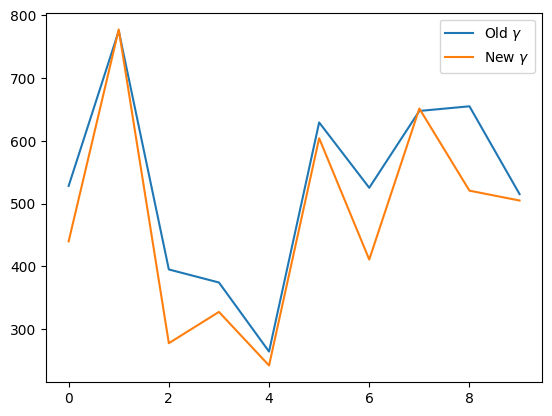


Started Sampling

HMC Iteration [42907/50100]; Accept Prob: 1.00; --> Accepted? True   

In [ ]:
results = main()

In [ ]:
# Plot results
for j in range(results['gamma_size']):
    plt.plot(results['gamma_vals_tracker'][:, j])
plt.show()

plt.plot(results['error_tracker'])
plt.xlabel("Iteration")
plt.ylabel("Error")
plt.show()

for itr in results['collected_ensembles'].keys():
    for j in range(results['gamma_size']):
        plt.hist(results['collected_ensembles'][itr][:, j], bins=100)
        plt.title(f"Iteration {itr+1}; Site {j+1}")
        plt.show()